In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import setGPU
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import h5py as h5
from gwpy.timeseries import TimeSeries

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers


setGPU: Setting GPU to: 1


/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [22]:
#Example of the time-series data we are working with

strain = TimeSeries.read('/cvmfs/gwosc.osgstorage.org/gwdata/O2/strain.4k/hdf.v1/L1/1185939456/L-L1_GWOSC_O2_4KHZ_R1-1186205696-4096.hdf5',format='hdf5.losc')
strain.plot()

In [66]:
# Load train and test data

train_start = 1185939456
num_train = 5
train_files = [train_start + i*4096 for i in range(num_train)]
detector = 'L1'
x = np.array([])

for file in train_files: 
    load = h5.File('/cvmfs/gwosc.osgstorage.org/gwdata/O2/strain.4k/hdf.v1/%s/%s/%s-%s_GWOSC_O2_4KHZ_R1-%s-4096.hdf5'%(detector, str(train_start), detector[0], detector, str(file)))
    x = np.concatenate((x, load['strain']['Strain'][()]), axis=0)

    
test_start = 1186988032
num_test = 1
test_files = [test_start + (num_train)*4096 + i*4096 for i in range(num_test)]
detector = 'L1'
y = np.array([])

for file in test_files: 
    load = h5.File('/cvmfs/gwosc.osgstorage.org/gwdata/O2/strain.4k/hdf.v1/%s/%s/%s-%s_GWOSC_O2_4KHZ_R1-%s-4096.hdf5'%(detector, str(test_start), detector[0], detector, str(file)))
    y = np.concatenate((y, load['strain']['Strain'][()]), axis=0)
    


In [24]:
#Data generator not sure if I'll need this (not used currently)

from data import H5Data
import glob

datadir = '/cvmfs/gwosc.osgstorage.org/gwdata/O2/strain.4k/hdf.v1/L1/1185939456/'
files = glob.glob(datadir + "/*")
files_val = files[:1]
files_train = files[1:10]

batch_size = 128
data_train = H5Data(batch_size = batch_size,
                    cache = None,
                    preloading=0,
                    primary_key='strain',
                    secondary_key='Strain')
data_train.set_file_names(files_train)
data_val = H5Data(batch_size = batch_size,
                    cache = None,
                    preloading=0,
                    primary_key='strain',
                    secondary_key='Strain')
data_val.set_file_names(files_val)
n_val=data_val.count_data()
n_train=data_train.count_data()
print("val data:", n_val)
print("train data:", n_train)

val data: 16777216
train data: 150994944


In [61]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(x.reshape(-1, 1))
X_test = scaler.transform(y.reshape(-1, 1))
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

Training data shape: (83886080, 1, 1)
Test data shape: (16777216, 1, 1)


In [64]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 1)              0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 16)             1152      
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 1)              17        
Total para

In [65]:
# fit the model to the data
nb_epochs = 100
batch_size = 2048
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.2).history

Train on 67108864 samples, validate on 16777216 samples
Epoch 1/100
 1038336/67108864 [..............................] - ETA: 16:12 - loss: nan

KeyboardInterrupt: 

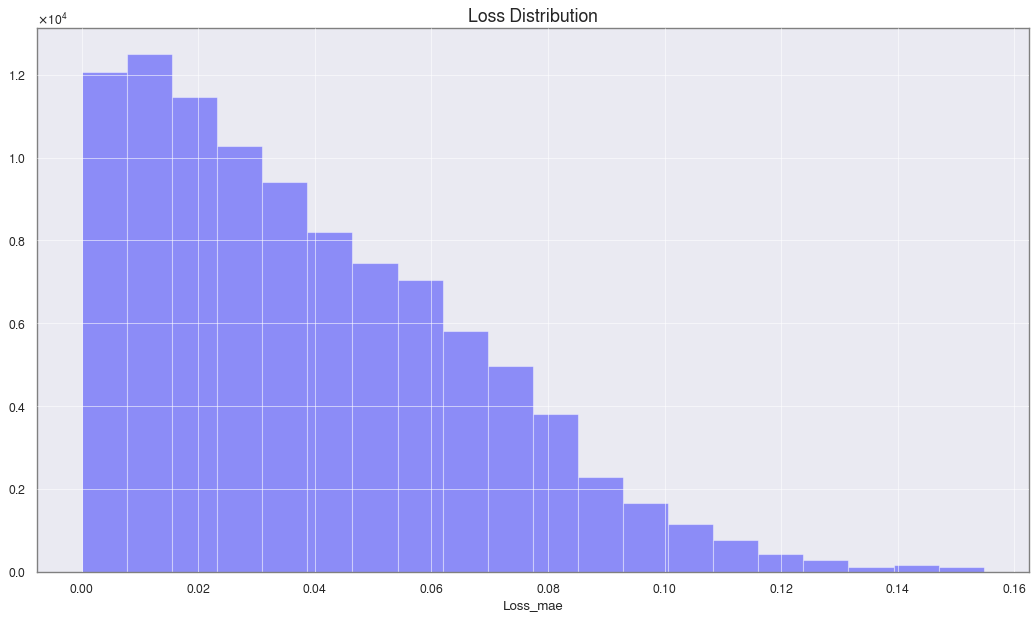

In [68]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)
#X_pred.index = train.index

scored = pd.DataFrame()
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.show()

In [70]:
scored.max()[0]

0.15478165720231696

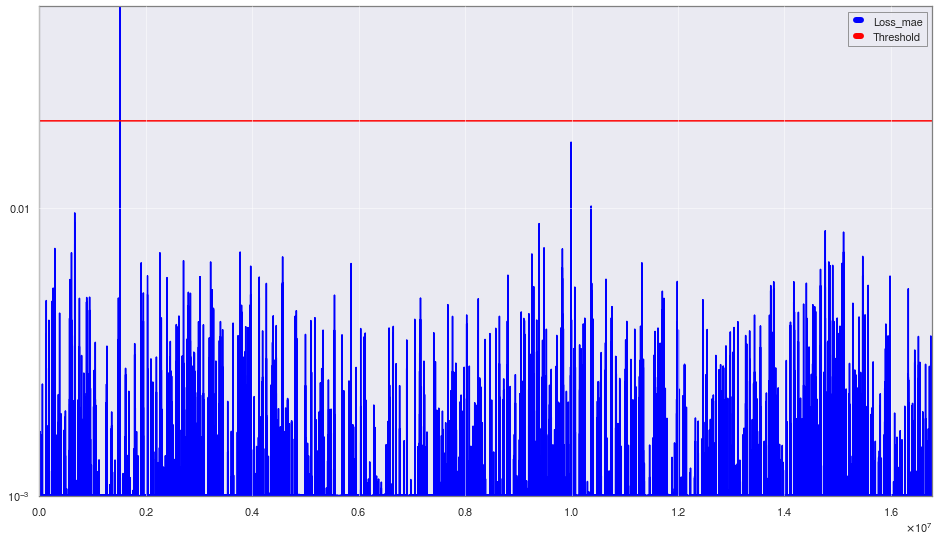

In [72]:
'''
X_pred_train = model.predict(X_test)
print(X_pred_train.shape)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train)
#X_pred_train.index = train.index
Xtest = X_test[:][:].reshape(X_test.shape[0], X_test.shape[2])
print(Xtest.shape)
'''

scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtest), axis = 1)
scored_train['Threshold'] = 0.02
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored_train.plot(logy=True,  figsize=(16,9), ylim=[1e-3,5e-2], color=['blue','red'])